### Overview

This notebook shows how to set up Hyper Networks and the interaction between the HyperNet and the TargetNet using PyTorch. It uses the data sets created in the `gen_sin_data.ipynb` notebook so make sure you have run that notebook first to create the data files.

### Modifying TargetNet Parameters

The TargetNet parameters have to be modified in different ways depending on if the model is being trained or is being used for normal inference.

##### During training:

We cannot directly modify the TargetNet parameters during training. If we attempted this, PyTorch will raise an exception that parameters were modified by an in-place operation. To run the TargetNet with the parameters from the HyperNet (`hy`), we can use `torch.func.functional_call(targetNet, tn_params, tx)` where `targetNet` is the TargetNet model, `tn_params` is a dictionary with key-value pairs of the parameter name and the new tensor, and `tx` is the TargetNet input tensor.

***Note:*** If you are unfamiliar, `math.prod()` is similar to `sum()`, but multiplies all values of an iterable together.

```python
# collect new parameters in a dict with name of parameter as key
idx, tn_params = 0, {}
for n, p in targetNet.named_parameters():
    tn_params[n] = hy[idx : idx + math.prod(p.shape)].reshape(*p.shape)
    idx += math.prod(p.shape)

# use PyTorch's functional_call
ty = torch.func.functional_call(targetNet, tn_params, tx)
```

##### During normal inference operation:

We cannot use the above method to modify TargetNet parameters during normal inference because using `functional_call()` will throw raise an exception when not training. However, not that we are not training, we can modify the parameter tensors in-place without raising an exception. Then, we simply use the `forward()` method of the TargetNet.

```python
# modify parameters in place
idx = 0
for p in targetNet.parameters():
    p[:] = hy[idx : idx + math.prod(p.shape)].reshape(*p.shape)
    idx += math.prod(p.shape)

# use TargetNet's forward method
ty = targetNet(tx)
```

In [ ]:
import math
from collections import OrderedDict

import numpy as np
import plotly
import plotly.graph_objects as go

import torch
from torch import optim
from torch.func import functional_call
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Linear, LSTM, ReLU, Tanh, MSELoss

# Model Creation

The following constants are used to define the TargetNet LSTM and the HyperNet DNN.

`HYPERNET_NODES` is a list of the number of nodes in each layer except for the output layer to the TargetNet.

`HYPERNET_ACTS` is a list of activation functions for each hidden layer *and* the output layer to the TargetNet.

In [ ]:
N_LSTM_LAYERS = 3
LSTM_IN_DIM = 1
LSTM_HIDDEN_DIM = 10
LSTM_OUT_DIM = 1

HYPERNET_NODES = [2, 8, 12, 12, 8, 2]
HYPERNET_ACTS = [ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), Tanh()]

# Training Parameters

The following constants are values used to configure the training settings.

In [ ]:
DEVICE = torch.device("cuda:0")
EPOCHS = 10
BATCH_SIZE = 25
LEARN_RATE = 1e-4
MODEL_NAME = "sinusoidal_hypernet.pt"
LOSS_FN = MSELoss()

# Load Data

Now we load the data arrays that were created with `gen_sin_data.ipynb`.

In [ ]:
TRAIN_DATA = np.load("sinusoidal-train.npz", allow_pickle=True)["arr_0"]
TTP_DATA = np.load("sinusoidal-test-tp.npz", allow_pickle=True)["arr_0"]
TNP_DATA = np.load("sinusoidal-test-np.npz", allow_pickle=True)["arr_0"]
VTP_DATA = np.load("sinusoidal-val-tp.npz", allow_pickle=True)["arr_0"]
VNP_DATA = np.load("sinusoidal-val-np.npz", allow_pickle=True)["arr_0"]

The following custom Dataset class is used to batch the train and test data sets with a Dataloader. `x` is the TargetNet input tensor, and `yhat` is the TargetNet output target values tensor.

In [ ]:
class RNNDataset(Dataset):

    def __init__(self, x: torch.Tensor, yhat: torch.Tensor) -> None:
        super().__init__()
        self.__x = x
        self.__yhat = yhat

    def __len__(self) -> int:
        return len(self.__x)

    def __getitem__(self, idx) -> tuple[torch.Tensor]:
        return self.__x[idx], self.__yhat[idx]

This function will parse the loaded datasets. It will convert all NumPy Arrays to PyTorch Tensors and ensure that the tensor is on the correct device and of a compatible data format. With this function defined we parse the training and test data sets and shuffle the training data set but not the test data sets.

In [ ]:
def parse_input_dataset(dataset: list, sh: bool) -> list:
    """
    load RNN data in dataset with `RNNDataset` and `DataLoader`

    :param dataset: list of data arrays
    :type dataset: list
    :param sh: shuffle Dataset if True, else False
    :type sh: bool
    :return: parse dataset
    :rtype: list
    """
    for i, ds in enumerate(dataset):
        hx = torch.from_numpy(ds["hx"]).to(DEVICE).float()
        tx = torch.from_numpy(ds["tx"]).to(DEVICE).float()
        tyhat = torch.from_numpy(ds["tyhat"]).to(DEVICE).float()
        rnn_data = DataLoader(
            RNNDataset(tx, tyhat), batch_size=BATCH_SIZE, shuffle=sh, drop_last=True
        )
        dataset[i] = [hx, rnn_data]
    return dataset


TRAIN_DATA = parse_input_dataset(TRAIN_DATA, True)
TTP_DATA = parse_input_dataset(TTP_DATA, False)
TNP_DATA = parse_input_dataset(TNP_DATA, False)

# Training Functions

This function will train the HyperNetwork model for a single epoch for a given HyperNet input array `hx`. Note that as described at the top of the notebook, we create dictionaries of the named parameter tensors with the output of the HyperNet. Once these are created, we run the TargNet on the batched noisy sine wave sequences using `functional_call()`.

The loss is calculated and summed across batches and returned to the main training loop below.

In [ ]:
def train_epoch(
    hyperNet_: Sequential,
    targetLSTM_: LSTM,
    targetSeq_: Sequential,
    hx: torch.Tensor,
    t_data: DataLoader,
    batch_size: int,
    loss_fn: Module,
    device: torch.device,
) -> torch.Tensor:

    # hidden/cell state dimensions
    hc_state_dim = (targetLSTM_.num_layers, batch_size, targetLSTM_.hidden_size)

    # run HyperNet
    hy = hyperNet_(hx)

    # collect TargetNet weights and biases in dicts
    idx, tn_params = 0, {}
    for n, p in targetLSTM_.named_parameters():
        tn_params[n] = hy[idx : idx + math.prod(p.shape)].reshape(*p.shape)
        idx += math.prod(p.shape)
    tns_params = {}
    for n, p in targetSeq_.named_parameters():
        tns_params[n] = hy[idx : idx + math.prod(p.shape)].reshape(*p.shape)
        idx += math.prod(p.shape)

    # run LSTM data in batches
    loss = 0
    for _, batch in enumerate(t_data):
        tx, tyhat = batch[0].to(device), batch[1].to(device)
        h0 = torch.zeros(*hc_state_dim).to(device)
        c0 = torch.zeros(*hc_state_dim).to(device)
        ty, _ = functional_call(targetLSTM_, tn_params, (tx, (h0, c0)))
        ty = functional_call(targetSeq_, tns_params, ty[:, -1, :])
        loss += loss_fn(ty, tyhat)

    return loss

Similarly to the `train_epoch()` function defined above, this function will perform the same operation but with the test data set passed. Note that `functional_call()` is still used to run the TargetNet.

In [ ]:
def test_epoch(
    hyperNet_: Sequential,
    targetLSTM_: LSTM,
    targetSeq_: Sequential,
    vhx: torch.Tensor,
    vt_data: DataLoader,
    batch_size: int,
    loss_fn: Module,
    device: torch.device,
) -> float:

    hc_state_dim = (targetLSTM_.num_layers, batch_size, targetLSTM_.hidden_size)

    loss = 0
    with torch.no_grad():

        # run HyperNet
        vhy = hyperNet_(vhx)

        # collect TargetNet weights and biases in dicts
        idx, vtn_params = 0, {}
        for n, p in targetLSTM_.named_parameters():
            vtn_params[n] = vhy[idx : idx + math.prod(p.shape)].reshape(*p.shape)
            idx += math.prod(p.shape)
        vtns_params = {}
        for n, p in targetSeq_.named_parameters():
            vtns_params[n] = vhy[idx : idx + math.prod(p.shape)].reshape(*p.shape)
            idx += math.prod(p.shape)

        # run LSTM data in batches
        for _, batch in enumerate(vt_data):
            vtx, vtyhat = batch[0].to(device), batch[1].to(device)
            vh0 = torch.zeros(*hc_state_dim).to(device)
            vc0 = torch.zeros(*hc_state_dim).to(device)
            vty, _ = functional_call(targetLSTM_, vtn_params, (vtx, (vh0, vc0)))
            vty = functional_call(targetSeq_, vtns_params, vty[:, -1, :])
            loss += loss_fn(vty, vtyhat)

    return loss.item()

# Create TargetNet

Now that our data is loaded and the train and test functions are defined, we have to create the Hyper Network models. We must create the TargetNet first so that we know the output dimension of the HyperNet. Here we create an LSTM with the values defined at the beginning of this notebook and a Linear layer and activation function also defined above. These two are tracked in separate variables to properly use in PyTorch but should be considered together as the TargetNet.

Once these two models are created, we need to calculate total number of parameters in the TargetNet and make sure that all are set to not require gradient so that they are not accidentally picked up by the backpropagation operations.

Finally we move both models to the inference device selected at the beginning of the notebook.

In [ ]:
# create TargetNet modules
targetLSTM = LSTM(LSTM_IN_DIM, LSTM_HIDDEN_DIM, N_LSTM_LAYERS, batch_first=True)
targetSeq = Sequential(
    Linear(LSTM_HIDDEN_DIM, LSTM_OUT_DIM),
    Tanh(),
)

# get number of parameters in TargetNet
target_params = 0
for p in targetLSTM.parameters():
    target_params += math.prod(p.shape)
    p.requires_grad = False
for p in targetSeq.parameters():
    target_params += math.prod(p.shape)
    p.requires_grad = False

# move modules to DEVICE
targetLSTM = targetLSTM.to(DEVICE)
targetSeq = targetSeq.to(DEVICE)

# Create HyperNet

Now that we know the total number of parameters in the TargetNet, we can create the HyperNet DNN. First we append the number of parameters in the TargetNet to the HyperNet nodes list, then create a Sequential model of alternating Linear layers and Activation functions defined above.

Finally, we also move the model to the selected inference device.

In [ ]:
HYPERNET_NODES.append(target_params)
layers = []
for i, act in enumerate(HYPERNET_ACTS):
    layers.append(Linear(HYPERNET_NODES[i], HYPERNET_NODES[i + 1]))
    layers.append(act)
hyperNet = Sequential(*layers)

hyperNet = hyperNet.to(DEVICE)

# Train Hyper Network

And finally we can start training the HyperNet! First we pass the HyperNet parameters to the optimizer. Note that the optimizer does ***not*** see the TargetNet parameters because we aren't attempting to create an LSTM that can generate sine waves, we are creating a DNN that can *tune* an LSTM to create sine waves of varying Amplitude and Frequency.

We also create a tuple of the dimensions that will be used for the LSTM Hidden and Cell state arrays.

For each epoch, we iterate over the training data sets and back propagate with the loss calculated in the `train_epoch()` function defined above. We then calculate test loss for the test data set with training HyperNet inputs and the test data set with unseen HyperNet inputs.

We output the model that has the best training loss and print out each loss value tracked during training at the end of each epoch.

In [ ]:
# create optimizer
optimizer = optim.Adam(hyperNet.parameters(), lr=LEARN_RATE)

# track loss over epochs
best_loss = torch.inf
loss, ttp_loss, tnp_loss = [], [], []

# dimension of LSTM hidden/cell states
hc_state_dim = (targetLSTM.num_layers, BATCH_SIZE, targetLSTM.hidden_size)

# iterate over epochs
for i in range(EPOCHS):

    # train HyperNet for this epoch
    loss_i = 0
    for ds in TRAIN_DATA:

        # HyperNet and TargetNet data
        hx, t_data = ds

        # run epoch
        optimizer.zero_grad()
        loss_b = train_epoch(
            hyperNet, targetLSTM, targetSeq, hx, t_data, BATCH_SIZE, LOSS_FN, DEVICE
        )

        # back propagate HyperNet
        loss_b.backward()
        optimizer.step()

        # track loss for HyperNet input set
        loss_i += loss_b.item()

    # test model with training parameters
    ttp_loss_i = 0
    for ds in TTP_DATA:
        vhx, vt_data = ds
        ttp_loss_i += test_epoch(
            hyperNet, targetLSTM, targetSeq, vhx, vt_data, BATCH_SIZE, LOSS_FN, DEVICE
        )

    # test model with new parameters
    tnp_loss_i = 0
    for ds in TNP_DATA:
        vhx, vt_data = ds
        tnp_loss_i += test_epoch(
            hyperNet, targetLSTM, targetSeq, vhx, vt_data, BATCH_SIZE, LOSS_FN, DEVICE
        )

    # track loss for epoch
    loss.append(loss_i)
    ttp_loss.append(ttp_loss_i)
    tnp_loss.append(tnp_loss_i)

    # save model if it has lowest loss
    if loss_i < best_loss:
        best_loss = loss_i
        hyperNet = hyperNet.cpu()
        torch.save(hyperNet.state_dict(), MODEL_NAME)
        hyperNet = hyperNet.to(DEVICE)

    # print training progress
    print(
        f"Epoch: {i+1:0>2} | Loss: {loss_i:.3e} | "
        f"Best Loss: {best_loss:.3e} | "
        f"TTP Loss: {ttp_loss_i:.3e} | "
        f"TNP Loss: {tnp_loss_i:.3e}"
    )

Epoch: 01 | Loss: 1.502e+02 | Best Loss: 1.502e+02 | TTP Loss: 1.921e-01 | TNP Loss: 1.681e-01
Epoch: 02 | Loss: 1.365e+01 | Best Loss: 1.365e+01 | TTP Loss: 3.268e-02 | TNP Loss: 3.346e-02
Epoch: 03 | Loss: 8.765e+00 | Best Loss: 8.765e+00 | TTP Loss: 1.765e-02 | TNP Loss: 2.045e-02
Epoch: 04 | Loss: 7.801e+00 | Best Loss: 7.801e+00 | TTP Loss: 1.227e-02 | TNP Loss: 1.708e-02
Epoch: 05 | Loss: 7.433e+00 | Best Loss: 7.433e+00 | TTP Loss: 8.642e-03 | TNP Loss: 1.329e-02
Epoch: 06 | Loss: 7.133e+00 | Best Loss: 7.133e+00 | TTP Loss: 7.449e-03 | TNP Loss: 1.111e-02
Epoch: 07 | Loss: 6.907e+00 | Best Loss: 6.907e+00 | TTP Loss: 8.183e-03 | TNP Loss: 1.001e-02
Epoch: 08 | Loss: 6.724e+00 | Best Loss: 6.724e+00 | TTP Loss: 9.892e-03 | TNP Loss: 9.543e-03
Epoch: 09 | Loss: 6.613e+00 | Best Loss: 6.613e+00 | TTP Loss: 8.181e-03 | TNP Loss: 8.520e-03
Epoch: 10 | Loss: 6.536e+00 | Best Loss: 6.536e+00 | TTP Loss: 7.452e-03 | TNP Loss: 8.245e-03
Epoch: 11 | Loss: 6.462e+00 | Best Loss: 6.462e+00

# Plot List History

Now that training has concluded, let's plot the loss history over each epoch.

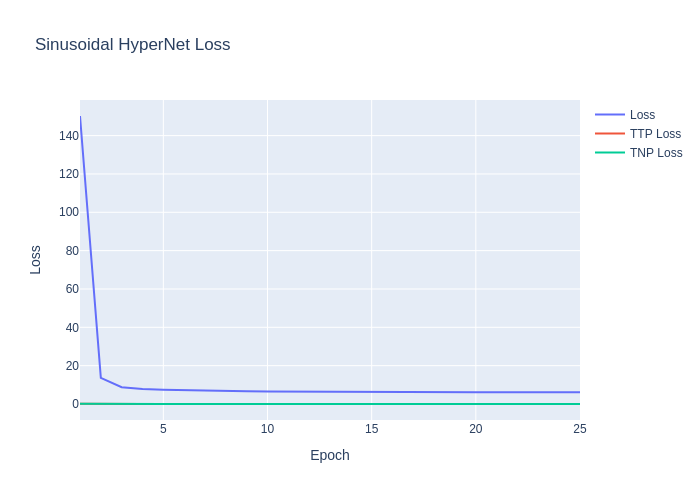

In [ ]:
loss_fig = go.Figure()
loss_fig.add_trace(
    go.Scatter(x=torch.arange(len(loss)) + 1, y=loss, name="Loss", mode="lines", showlegend=True)
)
loss_fig.add_trace(
    go.Scatter(
        x=torch.arange(len(ttp_loss)) + 1,
        y=ttp_loss,
        name="TTP Loss",
        mode="lines",
        showlegend=True,
    )
)
loss_fig.add_trace(
    go.Scatter(
        x=torch.arange(len(tnp_loss)) + 1,
        y=tnp_loss,
        name="TNP Loss",
        mode="lines",
        showlegend=True,
    )
)
loss_fig.update_layout(
    title="Sinusoidal HyperNet Loss",
    yaxis={"title": "Loss"},
    xaxis={"title": "Epoch"},
    hovermode="x unified",
)

loss_fig.show()

# Validation

Now we begin the validation process. First we load the model that was saved during the training loop.

In [ ]:
hyperNet.load_state_dict(torch.load(MODEL_NAME, weights_only=True))

<All keys matched successfully>

This function will act as the `forward()` function for our overall Hyper Network. The name was specifically chosen to match the name used by PyTorch for their models.

Note that unlike the training loop, we are not collecting dictionaries of tensors to use as a substiture for the TargetNet parameters. We are instead modifying the values of these tensors in place after we run the HyperNet.

We also use the `forward()` method of the TargetNet models, rather than using `functional_call()` like when we were training the HyperNet.

In [ ]:
def forward(
    hyperNet_: Sequential,
    targetLSMT_: LSTM,
    targetSeq_: Sequential,
    hx: torch.Tensor,
    tx: torch.Tensor,
) -> torch.Tensor:
    hy = hyperNet_(hx)

    idx = 0
    for p in targetLSMT_.parameters():
        p[:] = hy[idx : idx + math.prod(p.shape)].reshape(*p.shape)
        idx += math.prod(p.shape)
    for p in targetSeq_.parameters():
        p[:] = hy[idx : idx + math.prod(p.shape)].reshape(*p.shape)
        idx += math.prod(p.shape)

    hc_dims = (targetLSMT_.num_layers, tx.shape[0], targetLSMT_.hidden_size)
    h0 = torch.zeros(*hc_dims).to(DEVICE)
    c0 = torch.zeros(*hc_dims).to(DEVICE)

    y, _ = targetLSMT_(tx, (h0, c0))
    y = targetSeq_(y[:, -1, :])

    return y.detach()

This function is similar to the `parse_input_dataset()` function defined above. We still ensure that each NumPy array is converted to a PyTorch tensor on the selected inference device and of a compatible data format. In addition, we call the `forward()` function defined in the above cell to process the results and include the Hyper Network output array in the data set.

In [ ]:
def parse_validation_dataset(
    dataset: list, hyperNet_: Sequential, targetLSMT_: LSTM, targetSeq_: Sequential
) -> list:
    """
    load RNN data in dataset with `RNNDataset` and `DataLoader`

    :param dataset: list of data arrays
    :type dataset: list
    :return: parse dataset
    :rtype: list
    """
    for i, ds in enumerate(dataset):
        hx = torch.from_numpy(ds["hx"]).to(DEVICE).float()
        tx = torch.from_numpy(ds["tx"]).to(DEVICE).float()
        tyhat = torch.from_numpy(ds["tyhat"]).to(DEVICE).float()
        ty = forward(hyperNet_, targetLSMT_, targetSeq_, hx, tx)
        dataset[i] = [hx, tx, ty, tyhat]
    return dataset


VTP_DATA = parse_validation_dataset(VTP_DATA, hyperNet, targetLSTM, targetSeq)
VNP_DATA = parse_validation_dataset(VNP_DATA, hyperNet, targetLSTM, targetSeq)

Now let's plot our results to see how well the HyperNet can predict true sine waves for HyperNet inputs that were included in the training data set and HyperNet inputs that were *not* included in the training data set.

In [ ]:
colors = plotly.colors.qualitative.Plotly
color_count = 0

First we plot the results with the validation data set of true sine waves for HyperNet inputs that were included in the training data set and see how well the model predicts the sine waves.

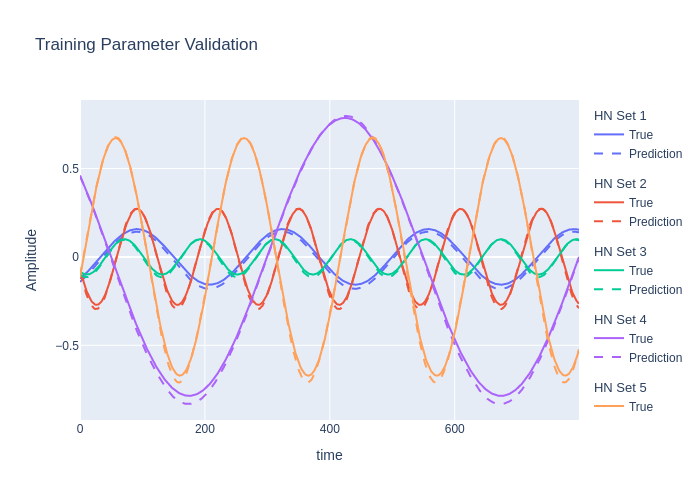

In [ ]:
reshape = (-1,)

vtp_fig = go.Figure()
vtp_fig.update_layout(
    title="Training Parameter Validation", yaxis={"title": "Amplitude"}, xaxis={"title": "time"}
)
for i, ds in enumerate(VTP_DATA):

    hx, tx, ty, tyhat = ds
    tyhat = tyhat.cpu().reshape(*reshape)
    ty = ty.cpu().reshape(*reshape)
    p_set = f"HN Set {i+1}"
    p_hover = "<br>    ".join([f"{x:.3e}" for x in hx.cpu().numpy()])

    vtp_fig.add_trace(
        go.Scatter(
            x=torch.arange(len(tx)),
            y=tyhat.cpu(),
            line={"color": colors[color_count]},
            name="True",
            showlegend=True,
            legendgroup=p_set,
            legendgrouptitle_text=p_set,
            hovertemplate=f"HyperNet Inputs:<br>    {p_hover}<br>" "<br>t: %{x}" "<br>a: %{y}",
        )
    )

    vtp_fig.add_trace(
        go.Scatter(
            x=torch.arange(len(tx)),
            y=ty,
            line={"color": colors[color_count], "dash": "dash"},
            name="Prediction",
            showlegend=True,
            legendgroup=p_set,
            legendgrouptitle_text=p_set,
            hovertemplate=f"HyperNet Inputs:<br>    {p_hover}<br>" "<br>t: %{x}" "<br>a: %{y}",
        )
    )

    color_count += 1
    if color_count == len(colors):
        color_count = 0

vtp_fig.show()

Overall, our prediction is not too bad! There is certainly room for improvement which could likely be resolved with more training epochs or by modifying the `NOISE_FACTOR` in the `gen_sin_data.ipynb` notebook.

Now let's see the results on the validation data set with HyperNet inputs that our model has never seen before.

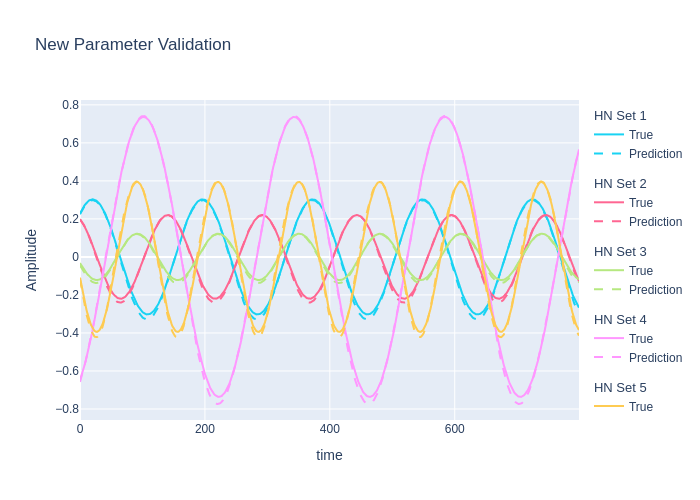

In [ ]:
vnp_fig = go.Figure()
vnp_fig.update_layout(
    title="New Parameter Validation",
    yaxis={"title": "Amplitude"},
    xaxis={"title": "time"},
)
for i, ds in enumerate(VNP_DATA):

    hx, tx, ty, tyhat = ds
    tyhat = tyhat.cpu().reshape(*reshape)
    ty = ty.cpu().reshape(*reshape)
    p_set = f"HN Set {i+1}"
    p_hover = "<br>    ".join([f"{x:.3e}" for x in hx.cpu().numpy()])

    vnp_fig.add_trace(
        go.Scatter(
            x=torch.arange(len(tx)),
            y=tyhat,
            line={"color": colors[color_count]},
            name="True",
            showlegend=True,
            legendgroup=p_set,
            legendgrouptitle_text=p_set,
            hovertemplate=f"HyperNet Inputs:<br>    {p_hover}<br>" "<br>t: %{x}" "<br>a: %{y}",
        )
    )

    vnp_fig.add_trace(
        go.Scatter(
            x=torch.arange(len(tx)),
            y=ty,
            line={"color": colors[color_count], "dash": "dash"},
            name="Prediction",
            showlegend=True,
            legendgroup=p_set,
            legendgrouptitle_text=p_set,
            hovertemplate=f"HyperNet Inputs:<br>    {p_hover}<br>" "<br>t: %{x}" "<br>a: %{y}",
        )
    )

    color_count += 1
    if color_count == len(colors):
        color_count = 0

vnp_fig.show()

Again, there is room for improvement but for a demonstration with as few epochs as were selected, these results are very promising!